### Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
import scipy.ndimage
from sklearn import linear_model
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.ensemble import StackingClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
RAND_STATE = 47
np.random.seed(RAND_STATE)

In [ ]:
folder = '../'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Get Updated clean and split files

In [ ]:
def get_train_test(tr = 'X_train.csv', te = 'X_test_all.csv'):
    # Returns a sample of original dataset
    # of 100k records of class 0 and all records of class 1
    # along with val and test datasets
    df = pd.read_csv(folder + tr)
    # test_df = pd.read_csv(folder + 'X_test.csv')
    test_all_df = pd.read_csv(folder + te)
    # Splitting for train and val
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 3:],
                                                    df.target,
                                                    test_size=0.2, 
                                                    random_state=RAND_STATE,
                                                    stratify = df['target'])
    X_test_all = test_all_df.iloc[:, 3:]
    
    class_dict = {0 : 100000,
                  1 :  y_train.value_counts()[1]}
    
    rus = RandomUnderSampler(sampling_strategy = class_dict,
                             random_state = RAND_STATE) 
    X_res, y_res = rus.fit_resample(X_train, y_train)
    X_res.to_csv(folder+'charan/X_res.csv')
    y_res.to_csv(folder+'charan/y_res.csv')
    
    del df, test_all_df
#   return X_train, X_val, y_train, y_val, X_test_all
    return X_res, X_val, y_res, y_val, X_test_all

### Model Training

In [ ]:
lr = linear_model.LogisticRegression()

# Creating a pipe using StandardScaler so that nested CV takes normalized data each time training set as 
# taken as input
# This is done so that there is no leakage of data from test to train set each time nested CV loops run
pipe_lr = Pipeline([('scaler', StandardScaler()), ('logreg', lr)])

# Setting up possible values of parameters (penalty, regularization strength and solver) to optimize over
p_grid_lr = {"logreg__penalty": ["l1", "l2", "elastiscnet", "none"],
              "logreg__C": [100, 10, 1, 0.1],
              "logreg__solver": ["newton-cg", "lbfgs", "liblinear", "saga"],
              "logreg__class_weight": ['balanced']}
              
clf_lr = GridSearchCV(estimator=pipe_lr, param_grid=p_grid_lr, scoring='roc_auc')
clf_lr.fit(X_train, y_train)
print(clf_lr.best_params_)

{'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [ ]:
lr_new = linear_model.LogisticRegression(C = 0.1, class_weight = 'balanced', solver = 'saga', penalty = 'l1', verbose = 1)

In [ ]:
lr_new.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 140 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='saga',
                   verbose=1)

In [ ]:
# inputs model, X_val and y_val to plot confusion matrix
def show_confusion_matrix(model, X_val, y_val):
    print('Confusion Matrix')
    plot_confusion_matrix(model, X_val, y_val)
    plt.show()
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))

    print('Accuracy of the model: ',  accuracy_score(y_val, y_pred))
    print('Recall of the model: ',    recall_score(y_val, y_pred))
    print('Precision of the model: ', precision_score(y_val, y_pred))
    print('F Measure of the model: ', f1_score(y_val, y_pred))

Logistic Regression - Confusion Matrix


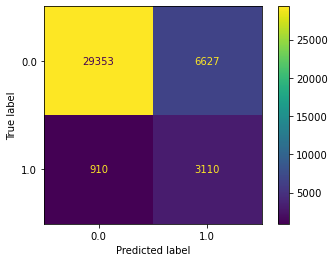

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     35980
         1.0       0.32      0.77      0.45      4020

    accuracy                           0.81     40000
   macro avg       0.64      0.79      0.67     40000
weighted avg       0.90      0.81      0.84     40000

Accuracy of the model:  0.811575
Recall of the model:  0.7736318407960199
Precision of the model:  0.319400225942282
F Measure of the model:  0.4521334593297957


In [ ]:
show_confusion_matrix(lr_new, X_val, y_val)

In [ ]:
# inputs model, X_val and y_val to plot RoC curve
def plot_roc(model, X_val, y_val):
    # calculate the fpr and tpr for 
    # all thresholds of the classification
    preds = model.predict_proba(X_val)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot
    plt.title('Receiver Operating Characteristic - Stacked Ensemble Model')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

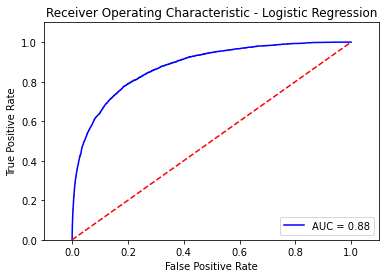

In [ ]:
plot_roc(lr_new, X_val, y_val)

In [ ]:
final_pred = lr_new.predict_proba(X_test)

In [ ]:
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = final_pred[:,1]
sub_df.to_csv("MSBA6420.Session002.submissionV69_log.csv", index=False)